In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot,EnhancerDatasetWithID
import pandas as pd
from tqdm import tqdm
import glob
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3,DeepSTARR


In [2]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_G+G-/ExplaiNN3_G+G-_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 75]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 75
target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = 83
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 75
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 350
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 78.4728
Epoch 1/200 -- Train Loss: 76.2104 , Validation Loss: 73.9245
------------------------Evaluation------------------------
Label 1: MSE=80.3309, RMSE=8.9628, MAE=8.9583, R^2=-1352.4581, Pearson=0.1985, Spearman=0.2121
Label 2: MSE=67.5262, RMSE=8.2174, MAE=8.2128, R^2=-1871.2662, Pearson=0.0795, Spearman=0.0886
Overall (Flattened): MSE=73.9285, RMSE=8.5982, MAE=8.5855, R^2=-1485.7496, Pearson=-0.0957, Spearman=-0.0726
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 74.2315
Epoch 2/200 -- Train Loss: 72.2126 , Validation Loss: 70.6575
------------------------Evaluation------------------------
Label 1: MSE=77.2277, RMSE=8.7879, MAE=8.7837, R^2=-1300.1740, Pearson=0.2664, Spearman=0.2690
Label 2: MSE=64.0959, RMSE=8.0060, MAE=8.0014, R^2=-1776.1577, Pearson=0.1054, Spearman=0.1230
Overall (Flattened): MSE=70.

In [3]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/best_pearson*.pth')

# Function to evaluate the model with a specific set of weights
def evaluate_model_with_weights(model, test_loader, weight_file):
    # Load the saved weights
    model.load_state_dict(torch.load(weight_file))
    
    # Set model to evaluation mode
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_fragment_ids = []

    # Disable gradient calculation for inference
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, fragment_ids = data  # Get inputs, labels, and fragment IDs
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            
            # Store predictions, true labels, and fragment IDs
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_fragment_ids.append(fragment_ids)  # Keep track of the sample IDs

    # Convert lists of numpy arrays into a single numpy array
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_fragment_ids = np.concatenate(all_fragment_ids, axis=0)
    
    return all_predictions, all_labels, all_fragment_ids

# Loop over each weight file and evaluate the model
for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
    predictions, labels, fragment_ids = evaluate_model_with_weights(input_model, test_loader, weight_file)
    
    # Prepare DataFrame columns for each label
    data = {
        'Fragment_ID': fragment_ids
    }
    # Assume two labels, handle each as separate columns
    for i in range(len(target_labels)):
        data[f'Predictions_{target_labels[i]}'] = predictions[:, i]
        data[f'True_{target_labels[i]}'] = labels[:, i]
    
    # Create DataFrame from the dictionary
    df_predictions = pd.DataFrame(data)
    
    # Save results to a CSV file
    output_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/prediction_results.csv'
    df_predictions.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")


Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/best_pearson_model_epoch_127.pth
Results saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/prediction_results.csv


# Train DeepSTARR

In [5]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-/DeepSTARR_G+G-_Metrics.csv')

temp_df = params

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Pred'

print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

#seed = best_seed
seed = 83
batch = best_batch
learning_rate= best_lr



input_model = DeepSTARR(num_classes = 2)

_, _, model_deepstarr, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

lr: 0.005    drop_out: 0.3
batch: 96    seed: 41
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 69.9539
Epoch 1/200 -- Train Loss: 8.1978 , Validation Loss: 1.5076
------------------------Evaluation------------------------
Label 1: MSE=1.4284, RMSE=1.1951, MAE=1.0684, R^2=-23.0658, Pearson=0.2157, Spearman=0.2094
Label 2: MSE=1.5884, RMSE=1.2603, MAE=1.1331, R^2=-43.0395, Pearson=0.0253, Spearman=0.0161
Overall (Flattened): MSE=1.5084, RMSE=1.2282, MAE=1.1008, R^2=-29.3340, Pearson=0.1549, Spearman=0.1361
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 1.1886
Epoch 2/200 -- Train Loss: 1.0613 , Validation Loss: 1.6029
------------------------Evaluation------------------------
Label 1: MSE=1.5952, RMSE=1.2630, MAE=1.1749, R^2=-25.8766, Pearson=0.1555, Spearman=0.1534
Label 2: MSE=1.6095, RMSE=1.2687, MAE=1.1883, R^2=-43.6255, Pearson=0.1706, Spearman=0.1837
Overall (Flattened): MSE=1.6023, RMSE=1.2658, MAE=1.1816, R^2

In [6]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Pred/best_pearson*.pth')

# Loop over each weight file and evaluate the model
for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
    predictions_d, labels_d, fragment_ids_d  = evaluate_model_with_weights(input_model, test_loader, weight_file)
    
    # Prepare DataFrame columns for each label
    data = {
        'Fragment_ID': fragment_ids
    }
    # Assume two labels, handle each as separate columns
    for i in range(len(target_labels)):
        data[f'Predictions_{target_labels[i]}'] = predictions_d[:, i]
        data[f'True_{target_labels[i]}'] = labels_d[:, i]
    
    # Create DataFrame from the dictionary
    df_predictions_d = pd.DataFrame(data)
    
  

#for weight_file in file_list:
#    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
#    predictions_d, labels_d, fragment_ids_d = evaluate_model_with_weights(input_model, test_loader, weight_file)
    
    # Print or save results
#    df_predictions_d = pd.DataFrame({
#        'Fragment_ID': fragment_ids_d,  # Add the fragment IDs
#        'Predictions': predictions_d.flatten(),  # Assuming 1D output
#        'True Labels': labels_d.flatten()
#    })
    
    # Save results to a CSV file
    #output_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_70NN/prediction_results.csv'
    #df_predictions.to_csv(output_file, index=False)
    #print(f"Results saved to {output_file}")

Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Pred/best_pearson_model_epoch_105.pth


In [7]:
df_predictions

,Fragment_ID,Predictions_GFP+,True_GFP+,Predictions_GFP-,True_GFP-
0,00_04_17,8.712347,8.793900,8.516946,8.865905
1,07_09_17,8.477186,8.620555,8.466915,8.584565
2,06_14_03,8.450142,8.413310,8.557813,8.465030
3,24_09_05,8.844982,8.763210,8.725422,8.626935
4,09_16_04,8.490125,8.293085,8.220875,8.361325
...,...,...,...,...,...
2141,09_00_20,8.518143,8.413515,8.511563,8.505215
2142,05_10_03,8.723476,8.887905,8.684061,8.784155
2143,21_06_00,8.372698,8.536855,8.510537,8.436580
2144,20_12_02,8.493924,8.388430,8.555000,8.127380


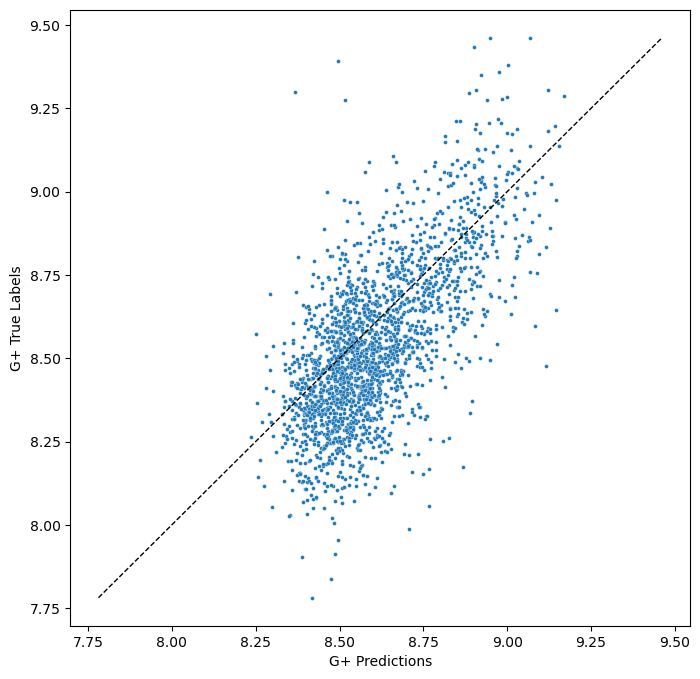

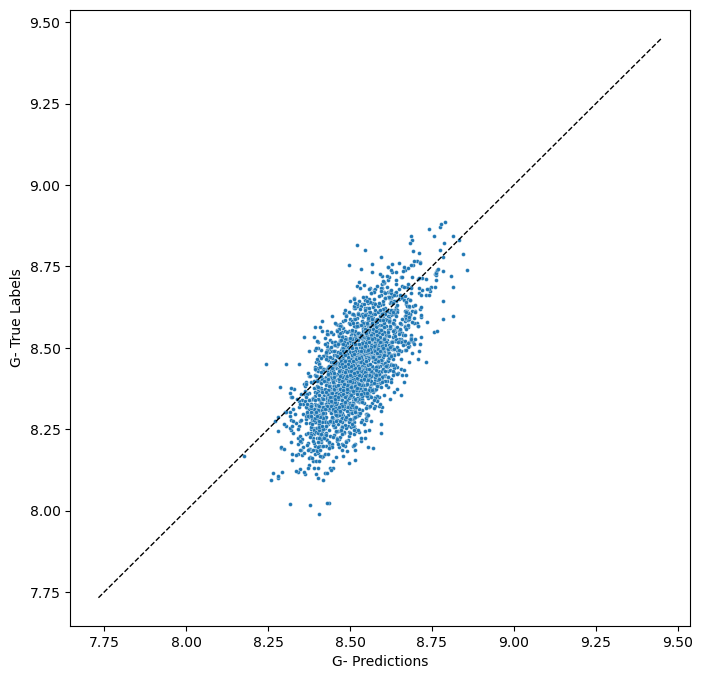

Pearson correlation for Predictions_GFP+: 0.6680390442323535
Pearson correlation for Predictions_GFP-: 0.44924276194955587


In [14]:
# Plot for Predictions_GFP+
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP+'], y=df_predictions['True_GFP+'], s=8)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP+'].min(), df_predictions['True_GFP+'].min())
max_val = max(df_predictions_d['Predictions_GFP+'].max(), df_predictions['True_GFP+'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G+ Predictions')
plt.ylabel('G+ True Labels')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G+')

# Show the plot
plt.show()

# Plot for Predictions_GFP-
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP-'], y=df_predictions['Predictions_GFP-'], s=8)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP-'].min(), df_predictions['True_GFP-'].min())
max_val = max(df_predictions_d['Predictions_GFP-'].max(), df_predictions['True_GFP-'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G- Predictions')
plt.ylabel('G- True Labels')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G-')

# Show the plot
plt.show()

from scipy.stats import pearsonr

# Calculate Pearson correlation for Predictions_GFP+
correlation_gfp_plus, _ = pearsonr(df_predictions_d['Predictions_GFP+'], df_predictions['True_GFP+'])
print(f"Pearson correlation for Predictions_GFP+: {correlation_gfp_plus}")

# Calculate Pearson correlation for Predictions_GFP-
correlation_gfp_minus, _ = pearsonr(df_predictions_d['Predictions_GFP-'], df_predictions['True_GFP-'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")


In [8]:
df_predictions_d

,Fragment_ID,Predictions_GFP+,True_GFP+,Predictions_GFP-,True_GFP-
0,00_04_17,8.702041,8.793900,8.583384,8.865905
1,07_09_17,8.663818,8.620555,8.519039,8.584565
2,06_14_03,8.558848,8.413310,8.587409,8.465030
3,24_09_05,8.919391,8.763210,8.759922,8.626935
4,09_16_04,8.560187,8.293085,8.425778,8.361325
...,...,...,...,...,...
2141,09_00_20,8.511091,8.413515,8.514641,8.505215
2142,05_10_03,8.838429,8.887905,8.711199,8.784155
2143,21_06_00,8.428327,8.536855,8.464479,8.436580
2144,20_12_02,8.617859,8.388430,8.595408,8.127380


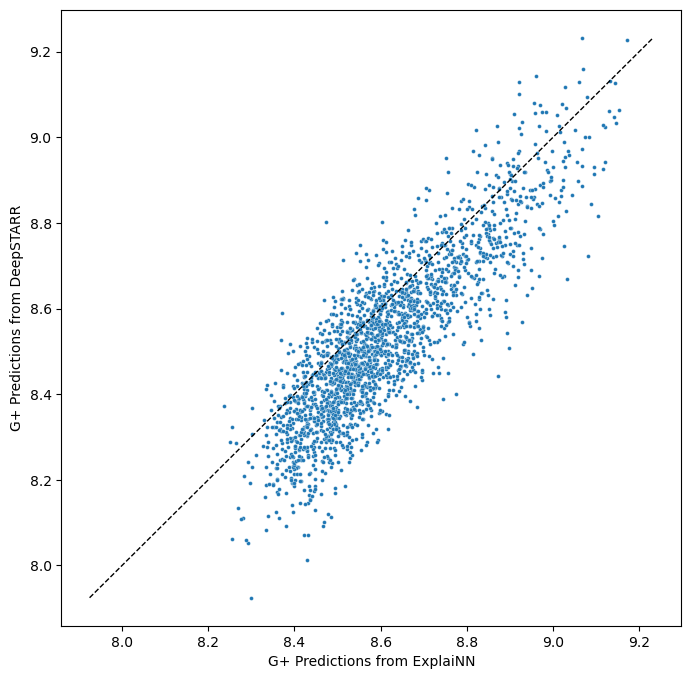

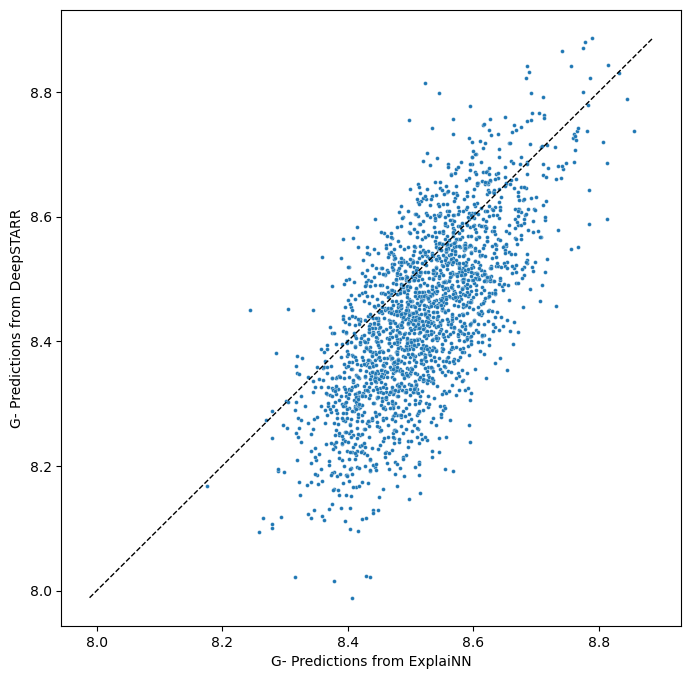

Pearson correlation for Predictions_GFP+: 0.8616452289221509
Pearson correlation for Predictions_GFP-: 0.697672623222179


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for Predictions_GFP+
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP+'], y=df_predictions['Predictions_GFP+'], s=8)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP+'].min(), df_predictions['Predictions_GFP+'].min())
max_val = max(df_predictions_d['Predictions_GFP+'].max(), df_predictions['Predictions_GFP+'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G+ Predictions from ExplaiNN')
plt.ylabel('G+ Predictions from DeepSTARR')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G+')

# Show the plot
plt.show()

# Plot for Predictions_GFP-
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP-'], y=df_predictions['Predictions_GFP-'], s=8)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP-'].min(), df_predictions['Predictions_GFP-'].min())
max_val = max(df_predictions_d['Predictions_GFP-'].max(), df_predictions['Predictions_GFP-'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G- Predictions from ExplaiNN')
plt.ylabel('G- Predictions from DeepSTARR')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G-')

# Show the plot
plt.show()

from scipy.stats import pearsonr

# Calculate Pearson correlation for Predictions_GFP+
correlation_gfp_plus, _ = pearsonr(df_predictions_d['Predictions_GFP+'], df_predictions['Predictions_GFP+'])
print(f"Pearson correlation for Predictions_GFP+: {correlation_gfp_plus}")

# Calculate Pearson correlation for Predictions_GFP-
correlation_gfp_minus, _ = pearsonr(df_predictions_d['Predictions_GFP-'], df_predictions['Predictions_GFP-'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")

